# Regressão - Previsão do valor de um ativo no dia seguinte

## Autores
- Felipe Bakowski Nantes de Souza  
- Vinicius Grecco Fonseca Mulato  
- Victor Soares


# 1.    Data set - Seleção

Usamos a biblioteca **yfinance** para baixar dados históricos de ações da Apple (AAPL) dos últimos 10 anos. O dataset contém dados diários de preços (abertura, máxima, mínima, fechamento) e volume negociado.

In [ ]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns

# baixar dados da Apple dos últimos 10 anos
df = yf.download("AAPL", period="10y", interval="1d", auto_adjust=True)
print("Shape:", df.shape)
df.head()

[*********************100%***********************]  1 of 1 completed

Shape: (2515, 5)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-10-21,25.564783,25.973784,25.551298,25.618717,167180800
2015-10-22,25.955803,25.955803,25.641187,25.692874,166616400
2015-10-23,26.760319,26.794028,26.142323,26.225471,237467600
2015-10-26,25.906368,26.546836,25.825467,26.535601,265335200
2015-10-27,25.742315,26.189519,25.616468,25.933332,279537600


# 2. Data set - Explicação

O `DataFrame` `df` reúne cotações diárias da Apple (ticker `AAPL`) obtidas via `yfinance` para os últimos 10 anos (`period="10y"`, `interval="1d"`). A coluna de índice (`Date`) marca cada pregão. A partir das séries básicas (`Open`, `High`, `Low`, `Close`, `Volume`) derivaram‑se as features abaixo:

- `Price_Range`: `High - Low`. Medida de volatilidade intraday.  
- `Price_Change`: `Close - Open`. Variação diária absoluta (momentum do dia).  
- `High_Low_Ratio`: `High / Low`. Proporção de amplitude do dia (volatilidade relativa).  
- `Return_1d`, `Return_3d`, `Return_5d`, `Return_10d`: retornos percentuais em janelas 1/3/5/10 dias. Capturam momentum em diferentes horizontes.  
- `MA_5`, `MA_10`, `MA_20`, `MA_50`: médias móveis do preço de fechamento (suavização de tendência).  
- `Volatility_5`, `Volatility_10`, `Volatility_20`: desvio padrão móvel do fechamento (risco/instabilidade em janelas distintas).  
- `Volume_MA_5`, `Volume_MA_10`: médias móveis do volume (interesse de mercado suavizado).  
- `BB_Middle`, `BB_Upper`, `BB_Lower`, `BB_Width`: bandas de Bollinger (MA_20 ± 2·Volatility_20) e largura (volatilidade implícita).  
- `RSI`: índice de força relativa (14 dias), indicador de sobrecompra/sobrevenda.  
- `MACD`, `MACD_Signal`, `MACD_Histogram`: MACD (EMA12−EMA26), sua linha de sinal (EMA9) e histograma (força do momentum).  
- `Momentum_5`, `Momentum_10`: diferença absoluta do fechamento em 5 e 10 dias (velocidade da variação).  
- `ROC_5`, `ROC_10`: rate of change (%) em 5 e 10 dias (retorno percentual em diferentes janelas).  
- `Target`: `Close.shift(-1)` — preço de fechamento do próximo dia (variável alvo).

Essas features procuram capturar preço, volume, volatilidade e momentum em múltiplas escalas temporais. O objetivo é treinar uma rede neural capaz de estimar o preço de fechamento (`Close`) do dia seguinte a partir desse histórico.

## Criação de novas features

In [ ]:
print("\n[3] CRIANDO FEATURES AVANÇADAS...")

# Features baseadas em preço
df['Price_Range'] = df['High'] - df['Low']  # Volatilidade intraday
df['Price_Change'] = df['Close'] - df['Open']  # Mudança diária
df['High_Low_Ratio'] = df['High'] / df['Low']  # Razão high/low

# Retornos percentuais
df['Return_1d'] = df['Close'].pct_change(1)  # Retorno de 1 dia
df['Return_3d'] = df['Close'].pct_change(3)  # Retorno de 3 dias
df['Return_5d'] = df['Close'].pct_change(5)  # Retorno de 5 dias
df['Return_10d'] = df['Close'].pct_change(10)  # Retorno de 10 dias

# Médias móveis
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

# Desvio padrão móvel (volatilidade)
df['Volatility_5'] = df['Close'].rolling(window=5).std()
df['Volatility_10'] = df['Close'].rolling(window=10).std()
df['Volatility_20'] = df['Close'].rolling(window=20).std()

# Média móvel do volume
df['Volume_MA_5'] = df['Volume'].rolling(window=5).mean()
df['Volume_MA_10'] = df['Volume'].rolling(window=10).mean()

# Bandas de Bollinger (simplificadas)
df['BB_Middle'] = df['MA_20']
df['BB_Upper'] = df['MA_20'] + 2 * df['Volatility_20']
df['BB_Lower'] = df['MA_20'] - 2 * df['Volatility_20']
df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']

# RSI simplificado (Relative Strength Index)
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# MACD (Moving Average Convergence Divergence)
exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

# Features de momentum
df['Momentum_5'] = df['Close'] - df['Close'].shift(5)
df['Momentum_10'] = df['Close'] - df['Close'].shift(10)

# Rate of Change (ROC)
df['ROC_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)) * 100
df['ROC_10'] = ((df['Close'] - df['Close'].shift(10)) / df['Close'].shift(10)) * 100

# Target: Preço de fechamento do próximo dia
df['Target'] = df['Close'].shift(-1)

print(f"Shape final após feature engineering: {df.shape}")
print(f"Total de features criadas: {df.shape[1] - 3}")  # -3 para Date, Close original e Target

## Crescimento da ação ao longo do tempo

# NOTA: COLOCAR TESTE DE HIPOTESE PARA VERIFICAR NORMALIDADE

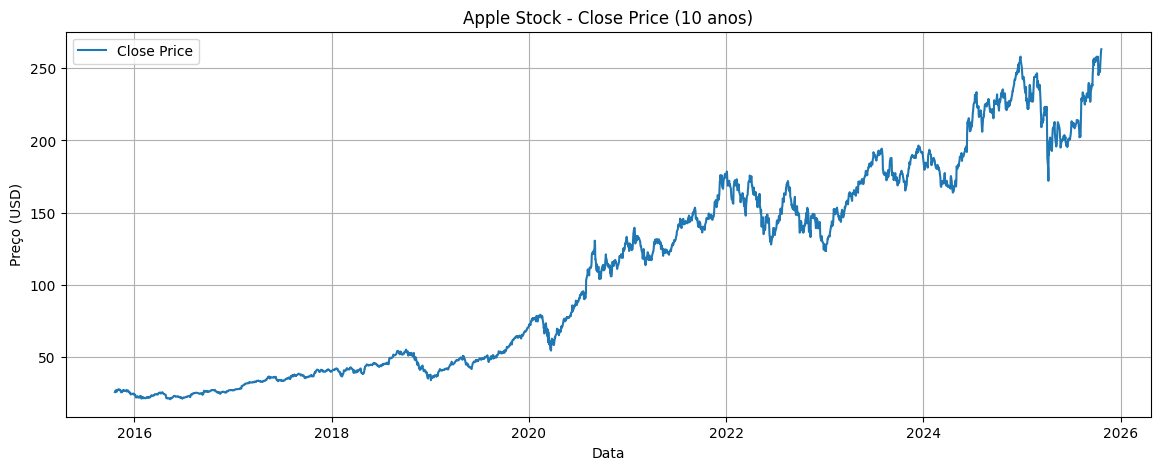

In [23]:
plt.figure(figsize=(14,5))
plt.plot(df.index, df['Close'], label='Close Price')
plt.title('Apple Stock - Close Price (10 anos)')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(df.index, df['Volume'], label='Close Price')
plt.title('Apple Stock - Close Price (10 anos)')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Colunas com valores faltando

In [ ]:
print("Valores faltantes por coluna:\n", df.isnull().sum())
df.dropna()

### vamos ter que colocar um dropna, pois em algumas features, por exemplo, Momentum 5 as 4 primeiras linhas não tem significado, já que é impossível calcular o valor

ARRUMAR TEXTO DEPOIS

## Visualizando as features

In [ ]:
# Seleciona colunas numéricas (inclui Target) e plota histogramas em grid
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Configura grid de subplots
n_cols = 4
n_features = len(numeric_cols)
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    # remove NaNs antes de plotar
    data = df[col].dropna()
    if data.size == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(col)
        ax.set_axis_off()
        continue
    sns.histplot(data, bins=50, kde=True, ax=ax, stat='density', color='tab:blue')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Density')

# Desativa eixos extras se houver
for j in range(n_features, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# 3. Limpeza & Normalização

### Abordagem: realizar um teste de hipótese e verificar normalidade de função, caso ela seja, utilizamos normalização z-score, caso não é min-max.

### Teste de D'agostin e Pearson -> p-valor baixo: não normal (min-max) / p-valor alto: possivelmente normal, plotar histograma e vizualizar o caso

In [ ]:
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
import os

def auto_scale_by_normality(df, train_ratio=0.8, alpha=0.05, target_col='Target', save_scalers=False, scalers_path='scalers'):
    """
    Para cada coluna numérica:
      - aplica D'Agostino-Pearson (normaltest) nos dados de treino (prefixo cronológico).
      - se p >= alpha -> StandardScaler (z-score); caso contrário -> MinMaxScaler (0-1).
    Retorna: df_scaled (com .dropna() aplicado), dict de scalers e dict com escolha por coluna.
    """
    df_clean = df.copy().dropna()
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

    include_target = target_col in numeric_cols
    if include_target:
        # decide se quer normalizar o target; aqui incluímos por padrão
        numeric_cols.remove(target_col)

    n = len(df_clean)
    train_len = max(int(n * train_ratio), 1)

    scalers = {}
    applied = {}

    for col in numeric_cols + ([target_col] if include_target else []):
        vals = df_clean[col].values.reshape(-1, 1)

        # se poucos exemplos no treino, força MinMax
        if train_len < 8:
            scaler = MinMaxScaler(feature_range=(0, 1))
            choice = 'minmax'
            scaler.fit(vals)
        else:
            try:
                stat, p = normaltest(vals[:train_len].ravel())
            except Exception:
                # se o teste falhar, assume não-normal
                p = 0.0
            if p >= alpha:
                scaler = StandardScaler()
                choice = 'zscore'
                scaler.fit(vals[:train_len])
            else:
                scaler = MinMaxScaler(feature_range=(0, 1))
                choice = 'minmax'
                scaler.fit(vals[:train_len])

        df_clean[col] = scaler.transform(vals).ravel()
        scalers[col] = scaler
        applied[col] = choice

    if save_scalers:
        os.makedirs(scalers_path, exist_ok=True)
        for k, sc in scalers.items():
            joblib.dump(sc, os.path.join(scalers_path, f'scaler_{k}.pkl'))

    return df_clean, scalers, applied

# Exemplo de uso: inserir após feature engineering e antes de modelagem
df_scaled, scalers, applied = auto_scale_by_normality(df, train_ratio=0.8, alpha=0.05, target_col='Target', save_scalers=True)
print("Normality-based scaler choices (sample):")
for k, v in list(applied.items())[:20]:
    print(f"  {k}: {v}")

# Plota comparação rápida de algumas features (orig vs scaled)
cols = list(applied.keys())[:6]
fig, axes = plt.subplots(len(cols), 2, figsize=(10, 3 * len(cols)))
for i, c in enumerate(cols):
    sns.histplot(df[c].dropna(), bins=50, kde=True, ax=axes[i, 0], color='tab:blue')
    axes[i, 0].set_title(f"{c} (orig)")
    sns.histplot(df_scaled[c].dropna(), bins=50, kde=True, ax=axes[i, 1], color='tab:orange')
    axes[i, 1].set_title(f"{c} (scaled: {applied[c]})")
plt.tight_layout()
plt.show()